# Milestone 3 

## Library installations and imports

In [1]:
! pip install TextBlob
! pip install plotly
! pip install nltk
! pip install vaderSentiment
! pip install scikit-learn
! pip install torch torchvision

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import os

import re
from textblob import TextBlob
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from datetime import datetime, date, time
from dateutil.parser import parse

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
nltk.download('punkt')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jamallahjouji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jamallahjouji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamallahjouji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamallahjouji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Setting up a color blind friendly pallete

CB_color_cycle = ['#377eb8','#ff7f00','#4daf4a',
                  '#f781bf','#a65628','#984ea3',
                  '#999999','#e41a1c','#dede00']

In [6]:
pd.set_option('display.max_rows', 10)

## Loading data

In [7]:
# Importing the data
movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
characters = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

# Importing txt files
name_clusters = pd.read_csv('MovieSummaries/name.clusters.txt', sep = '\t', header = None)
summaries_off = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header = None)
tv_tropes = pd.read_csv('MovieSummaries/tvtropes.clusters.txt', sep = '\t', header = None)

# Loading the NRC lexicon emotion intensity data
data_NRC = pd.read_table("NRC-lexicon/NRC-Emotion-Intensity-Lexicon-v1-ForVariousLanguages-withZeroIntensityEntries.txt")


In [8]:
movies.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie Name', 'Movie Release Date', 'Movie Box Office Revenue', 'Movie Runtime', 'Movie Languages', 'Movie Countries', 'Movie Genres']
name_clusters.columns = ['Name', 'Freebase Movie ID']
summaries_off.columns = ['Wikipedia Movie ID', 'Plot Summary']
characters.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie Release Date', 'Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethinicity', 'Actor Name', 'Actor Age', 'Freebase Character Map', 'Unknown ID1', 'Unknown ID1']

data_filt = data_NRC.iloc[:,0:9].copy()

In [9]:
display(movies)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


## Cleaning the data

In [10]:
def extract_language(language_data):
    language_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, language_data)
    for match in matches:
        language_names.append(match[1].split(' ')[0])  # Extract the language name
    return ','.join(language_names)

def extract_countries(country_data):
    country_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, country_data)
    for match in matches:
        country_names.append(match[1])  # Extract the country name
    return ','.join(country_names)


def extract_genres(genre_data):
    genre_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, genre_data)
    for match in matches:
        genre_names.append(match[1])  # Extract the genre name
    return ','.join(genre_names)

def extract_first_genre(genre_list):
    if genre_list:
        return genre_list[0]
    else:
        return None 

# Function to extract the release year from the date
def extract_release_year(date_str):
    try:
        # Attempt to extract the year from the 'YYYY-MM-DD' format
        return pd.to_datetime(date_str).year
    except (ValueError, TypeError):
        try:
            # Attempt to extract the year from 'YYYY' format
            return int(date_str)
        except ValueError:
            return None  # Return None for invalid or missing dates
        
def contains_nan(lst):
    return any(pd.isna(item) for item in lst)

def is_single_nan(lst):
    return len(lst) == 1 and pd.isna(lst[0])

In [11]:
movies["Movie Languages"] = movies["Movie Languages"].apply(extract_language) # extract languages
movies["Movie Countries"] = movies["Movie Countries"].apply(extract_countries) # extract countries
movies["Movie Genres"] = movies["Movie Genres"].apply(extract_genres) # extract genres
movies['Movie Release Date'] = pd.to_datetime(movies['Movie Release Date'], errors='coerce') # convert the release date into datetime format
movies['Movie Release Year'] = movies['Movie Release Date'].apply(extract_release_year) # extract only the year

In [12]:
movies['Movie Genres'] = movies['Movie Genres'].apply(lambda x: x.split(','))
movies['Movie Countries'] = movies['Movie Countries'].apply(lambda x: x.split(','))
movies['Movie Languages'] = movies['Movie Languages'].apply(lambda x: x.split(','))

movies['Main Genre'] = movies['Movie Genres'].apply(extract_first_genre) #extract first genre as main genre

In [13]:
# Identify all duplicates (including the first occurrence)
duplicates = movies[movies.duplicated(subset='Movie Name', keep=False)].sort_values(by='Movie Name').copy()

display(duplicates)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre
77290,8422241,/m/0272wbj,100 Days,1991-01-01,NaN,161.0,[Hindi],[India],"[Horror, Suspense, World cinema]",1991.0,Horror
18992,15498803,/m/03mc7x8,100 Days,2001-02-01,NaN,100.0,[English],[United Kingdom],[Drama],2001.0,Drama
12205,31239628,/m/0gj9wpb,100% Love,2011-04-01,NaN,140.0,[Telugu],[],[Romantic comedy],2011.0,Romantic comedy
69188,34757217,/m/0j3df_d,100% Love,2012-01-20,NaN,NaN,[Bengali],[India],"[Romance Film, Comedy film]",2012.0,Romance Film
17891,33940717,/m/0j626hk,12,2003-06-27,NaN,124.0,[English],[United States of America],"[Comedy film, Musical, Indie]",2003.0,Comedy film
...,...,...,...,...,...,...,...,...,...,...,...
79,11353896,/m/02r8pmz,Zindagi,1976-01-01,NaN,NaN,[Hindi],[India],[Bollywood],1976.0,Bollywood
75600,33215343,/m/0h67l5w,Zindagi,1940-01-01,NaN,120.0,[Hindi],[India],"[Family Film, Drama]",1940.0,Family Film
40871,11353680,/m/02r8p2s,Zindagi,1964-01-01,NaN,NaN,[Hindi],[India],"[Family Film, Drama, Musical]",1964.0,Family Film
74801,31543513,/m/0glpvqt,Zoetrope,NaT,NaN,73.0,[],[],"[Mystery, Fantasy]",NaN,Mystery


As we can see, some movies have the same name but not the same ID (Wikipedia and Freebase). Retaining duplicates in our movie dataset is crucial because each entry with a unique Wikipedia or Freebase ID, despite sharing the same name, likely represents a different version, adaptation, or international release of a movie. Ignoring these duplicates could result in the loss of valuable data about variations in movie production, cultural adaptations, and historical significance.

In [14]:
movies_summary = movies.merge(summaries_off, how = 'inner', on = 'Wikipedia Movie ID')
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,{{plot}} The film opens with a Great Western e...
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,Two former National Oceanic Atmospheric Admini...
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,{{No plot}} This film follows 12 years in the ...
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"The story takes place in the year 2092,The Sup..."


## Text pre-processing

In [15]:
def preprocess_summary(text):
    """
    Tokenize, lemmatize, remove stopwords and punctuations from an input text.
    
    Parameters
    ----------
    text: str, input text
    
    Returns
    -------
    str, preprocessed text
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in string.punctuation]
    
    return " ".join([lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words])

def preprocess_summaries(readpath, savepath=None):
    """
    Preprocess all movie summaries.
    
    Parameters
    ----------
    readpath: str, path to original summaries (.txt)
    savepath: str, path to preprocessed summaries (.csv)
    
    Returns
    -------
    original_summaries: list, original summaries
    df: pandas.DataFrame, preprocessed summaries with movie_id as index
    """
    with open(readpath, encoding='utf-8') as f:
        content = f.readlines()
    original_summaries = [x.strip() for x in content] 
    summaries = [tokenize(d).split() for d in original_summaries]
    summaries = {summary[0]: " ".join(summary[1:]) for summary in summaries}
    
    df = pd.DataFrame.from_dict(summaries, orient='index', columns=['text'])
    df.index = df.index.astype('int64').rename('movie_id')
    
    if savepath is not None:
        df.to_csv(savepath)
    return original_summaries, df

def clean_text(text):
    # Remove all '{{XX}}' patterns, HTML tags if any & extra white spaces
    text = re.sub(r'\{\{[^}]*\}\}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove each specific typos
    specific_strings = [r'\{\{Plot\|date', r'\{\{plot\|date', r'\{\{plot\|section\|date', r'\{\{Plot\|section\|date']
    for string in specific_strings:
        text = re.sub(string, '', text)

    return text


def tokenize(text):
    """
    Tokenize, lemmatize, remove stopwords and punctuations from an input text.
    
    Parameters
    ----------
    text: str, input text
    
    Returns
    -------
    str, preprocessed text
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in string.punctuation]
    
    return " ".join([lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words])

In [16]:
with open("./MovieSummaries/plot_summaries.txt", encoding='utf-8') as f:
    content = f.readlines()
original_summaries = [x.strip() for x in content] 
summaries = [preprocess_summary(d).split() for d in original_summaries]
summaries = {summary[0]: summary[1:] for summary in summaries}

In [17]:
movies_summary['Plot Summary'] = movies_summary['Plot Summary'].apply(clean_text)
movies_summary = movies_summary.copy()
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"Every hundred years, the evil Morgana returns ..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,The film opens with a Great Western express sp...
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,Two former National Oceanic Atmospheric Admini...
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,This film follows 12 years in the lives of 3 I...
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"The story takes place in the year 2092,The Sup..."


## Data exploration

In [18]:
print((movies_summary.isna().sum() / movies_summary.shape[0]) * 100)

Wikipedia Movie ID           0.000000
Freebase Movie ID            0.000000
Movie Name                   0.000000
Movie Release Date           6.205573
Movie Box Office Revenue    82.023031
                              ...    
Movie Countries              0.000000
Movie Genres                 0.000000
Movie Release Year           6.205573
Main Genre                   0.000000
Plot Summary                 0.000000
Length: 12, dtype: float64


We observe a notable amount of missing data in 'Movie Release Date' (6.21%) and a significant gap in 'Movie Box Office Revenue' (82.02%). This indicates challenges in analyzing release patterns and financial success.

In [19]:
# Get compound sentiment score for text

def plot_sentiment_score(text_list):
    text = " ".join(text_list)  # Convert list of words to a single string
    return TextBlob(text).sentiment.polarity


In [22]:
# Convert keys of 'summaries' from strings to ints
summaries_int_keys = {int(k): v for k, v in summaries.items()}

# Filter the DataFrame to only include rows where 'Wikipedia movie ID' is a key in the updated 'summaries' dictionary
movies_summary = movies_summary[movies_summary['Wikipedia Movie ID'].isin(summaries_int_keys.keys())]

# Add plot summary to DataFrame
movies_summary['Plot Summary'] = movies_summary['Wikipedia Movie ID'].map(summaries_int_keys)

In [23]:
# Apply the functions to DataFrame
movies_summary['Sentiment score plot'] = movies_summary['Plot Summary'].apply(plot_sentiment_score)

In [24]:
movies_summary

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary,Sentiment score plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"[set, second, half, 22nd, century, film, depic...",-0.075099
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,"[series, murder, rich, young, woman, throughou...",0.039072
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"[eva, upper, class, housewife, becomes, frustr...",0.152296
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"[every, hundred, year, evil, morgana, return, ...",-0.036790
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"[adam, san, francisco-based, artist, work, cab...",0.162716
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,"[plot, film, open, great, western, express, sp...",-0.052381
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,"[two, former, national, oceanic, atmospheric, ...",0.095833
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,"[plot, film, follows, 12, year, life, 3, irish...",0.010000
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"[story, take, place, year, 2092, super, dimens...",0.185669


### Movie Releases Over Time

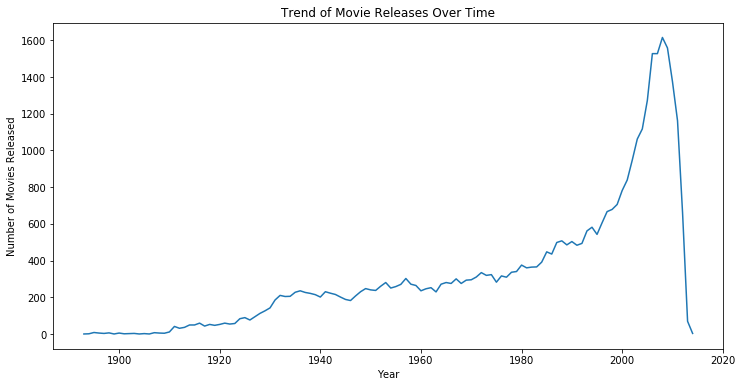

In [25]:
plt.figure(figsize=(12, 6))
movies_summary.groupby('Movie Release Year').size().plot(kind='line')
plt.title('Trend of Movie Releases Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.show()


### Distribution of Sentiment Scores

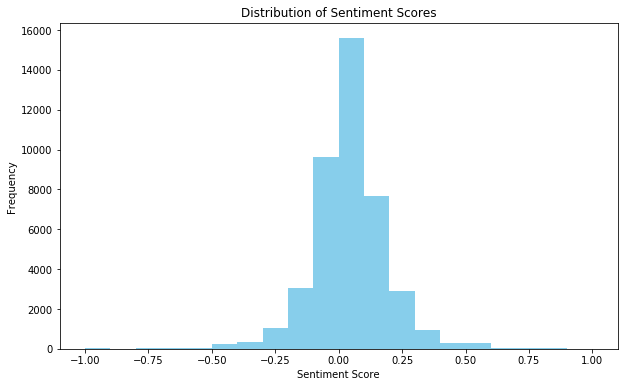

In [26]:
plt.figure(figsize=(10, 6))
movies_summary['Sentiment score plot'].plot(kind='hist', bins=20, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


## Generations

In [27]:
# Create generations with name, start year and end year (considering oldest movie in dataset)

generations_dict = {
    "Generation": ["Lost Generation", "Greatest Generation", "Silent Generation", "Baby Boomers", 
                   "Generation X", "Millennials", "Generation Z", "Generation Alpha"],
    "Start Year": [1883, 1901, 1928, 1946, 1965, 1981, 1997, 2010],
    "End Year": [1900, 1927, 1945, 1964, 1980, 1996, 2009, 2023]
}
generations = pd.DataFrame(generations_dict)

In [28]:
generations

,Generation,Start Year,End Year
0,Lost Generation,1883,1900
1,Greatest Generation,1901,1927
2,Silent Generation,1928,1945
3,Baby Boomers,1946,1964
4,Generation X,1965,1980
5,Millennials,1981,1996
6,Generation Z,1997,2009
7,Generation Alpha,2010,2023


In [29]:
# Function to determine the generation of a given year
def get_generation(year):
    for _, row in generations.iterrows():
        if row['Start Year'] <= year <= row['End Year']:
            return row['Generation']
    return "Unknown Generation"

In [30]:
movies_summary['Generation'] = movies_summary['Movie Release Year'].apply(get_generation)

In [31]:
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary,Sentiment score plot,Generation
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"[set, second, half, 22nd, century, film, depic...",-0.075099,Generation Z
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,"[series, murder, rich, young, woman, throughou...",0.039072,Millennials
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"[eva, upper, class, housewife, becomes, frustr...",0.152296,Millennials
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"[every, hundred, year, evil, morgana, return, ...",-0.036790,Generation Z
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"[adam, san, francisco-based, artist, work, cab...",0.162716,Generation Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,"[plot, film, open, great, western, express, sp...",-0.052381,Silent Generation
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,"[two, former, national, oceanic, atmospheric, ...",0.095833,Generation Alpha
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,"[plot, film, follows, 12, year, life, 3, irish...",0.010000,Generation Alpha
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"[story, take, place, year, 2092, super, dimens...",0.185669,Millennials


In [32]:
# Count the number of movies per generation
movies_per_generation = movies_summary['Generation'].value_counts()

# Display the result
print(movies_per_generation)

Generation Z           14298
Millennials             7636
Generation X            4978
Baby Boomers            4750
Silent Generation       3582
Generation Alpha        3272
Unknown Generation      2619
Greatest Generation     1033
Lost Generation           36
Name: Generation, dtype: int64


### Number of Movies Released Per Generation

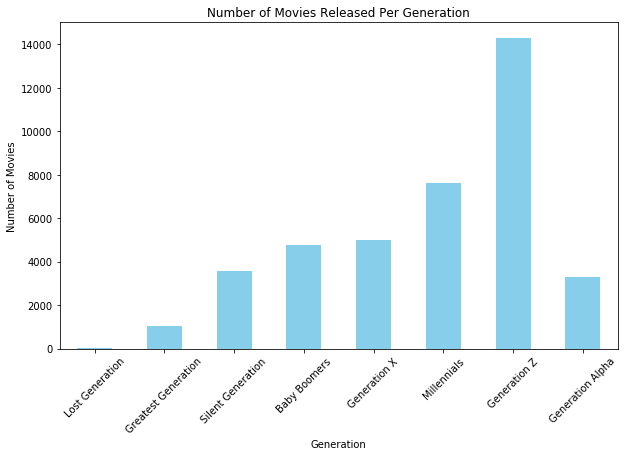

In [33]:
# Sort the count in the same order as the generations are defined
sorted_movies_per_generation = movies_per_generation.reindex(generations['Generation']).fillna(0)

# Plotting
plt.figure(figsize=(10,6))
sorted_movies_per_generation.plot(kind='bar', color='skyblue')
plt.title('Number of Movies Released Per Generation')
plt.xlabel('Generation')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

### Sentiment Scores by Generation

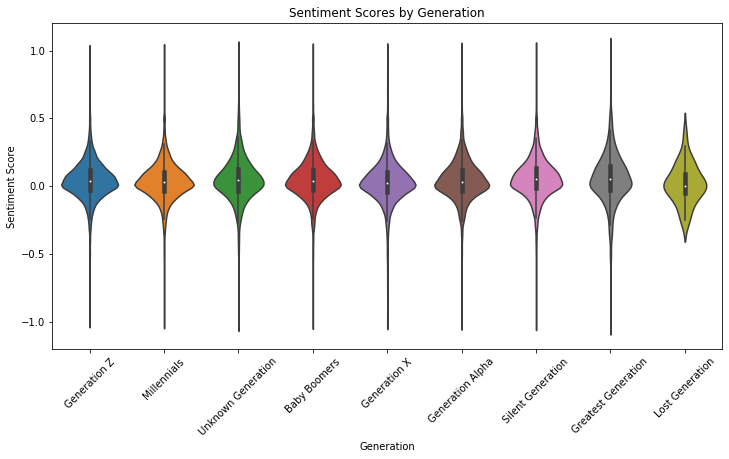

In [34]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Generation', y='Sentiment score plot', data=movies_summary)
plt.title('Sentiment Scores by Generation')
plt.xlabel('Generation')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


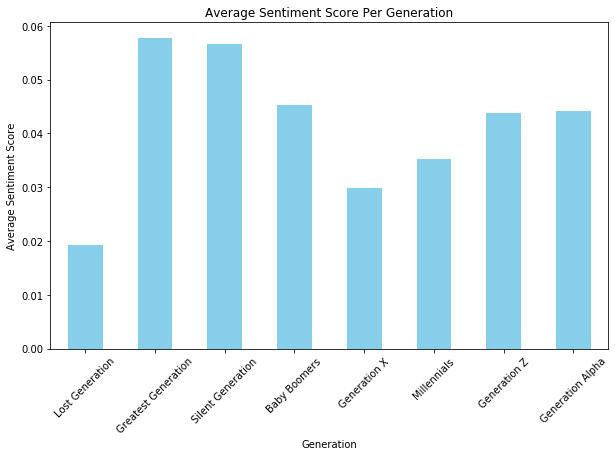

In [35]:
# Group by generation and calculate average sentiment score
avg_sentiment_per_generation = movies_summary.groupby('Generation')['Sentiment score plot'].mean()

# Sort the average sentiment score in the same order as the generations are defined
sorted_avg_sentiment_per_generation = avg_sentiment_per_generation.reindex(generations['Generation']).fillna(0)

# Plotting
plt.figure(figsize=(10,6))
sorted_avg_sentiment_per_generation.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score Per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

- **Greatest Generation**: Exhibiting the highest average sentiment score, this suggests that movies from or about this era (1901-1927) may be characterized by more positive themes or have been received more positively by audiences. This time, often remembered for the Roaring Twenties, might be depicted in films with a sense of nostalgia and positivity.

- **Lost Generation & Baby Boomers**: These generations show lower average sentiment scores, which could reflect the complex and tumultuous events during these times, such as World War I and the Vietnam War, respectively. Films from these periods or about these generations may thus have a more serious or contemplative tone.

- **Generation X, Millennials, & Generation Z**: The sentiment scores are quite consistent across these generations, which might indicate a stability in the emotional content of movies or a balance between different genres and themes from 1965 to 2009.

- **Generation Alpha**: Although this generation is still very young, the slightly higher sentiment score compared to Millennials and Generation Z could be due to the prevalence of family-friendly and animated films that generally carry positive sentiments.


## Genres and Generations

### Top 10 Movie Main Genres Distribution

In [69]:
# Identify the top 10 most prevalent genres
top_genres = movies_summary['Main Genre'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only the top genres
movies_top_genres = movies_summary[movies_summary['Main Genre'].isin(top_genres)]


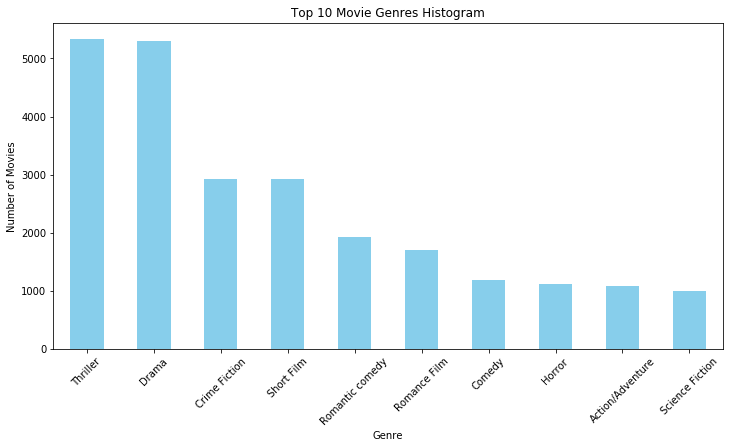

In [70]:
genre_counts = movies_summary['Main Genre'].value_counts().head(10)

# Plotting
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Movie Genres Histogram')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


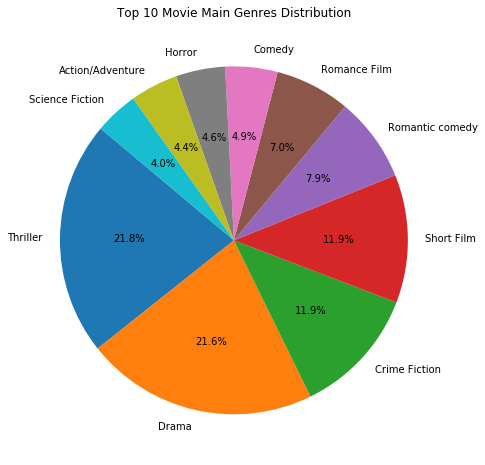

In [71]:
plt.figure(figsize=(12, 8))
movies_summary['Main Genre'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Movie Main Genres Distribution')
plt.ylabel('') 
plt.show()


### Movie Genre Distribution Across Generations


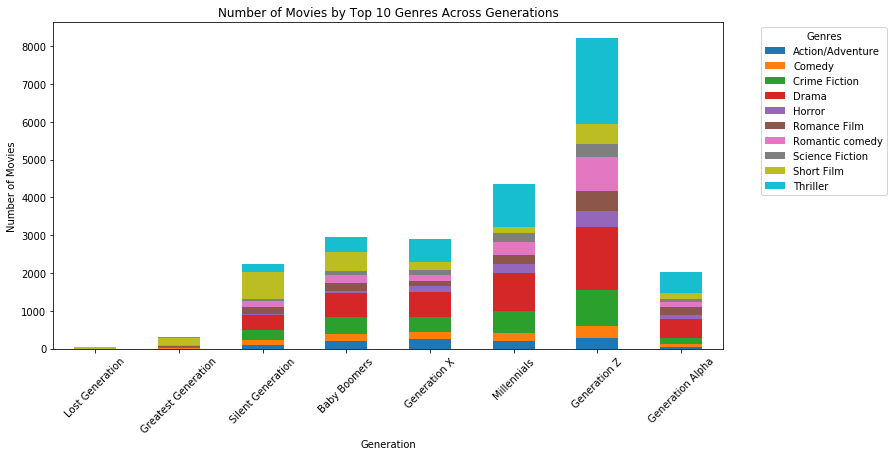

In [72]:
generations_order = generations['Generation'].tolist()  # This assumes 'generations' is in the correct order
movies_top_genres['Generation'] = pd.Categorical(movies_top_genres['Generation'], categories=generations_order, ordered=True)

# Count the occurrences of the top genres within each generation
genre_by_generation = pd.crosstab(movies_top_genres['Generation'], movies_top_genres['Main Genre'])

genre_by_generation = genre_by_generation.reindex(generations_order)

# Plotting a stacked bar chart
genre_by_generation.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Movies by Top 10 Genres Across Generations')
plt.xlabel('Generation')
plt.ylabel('Number of Movies')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


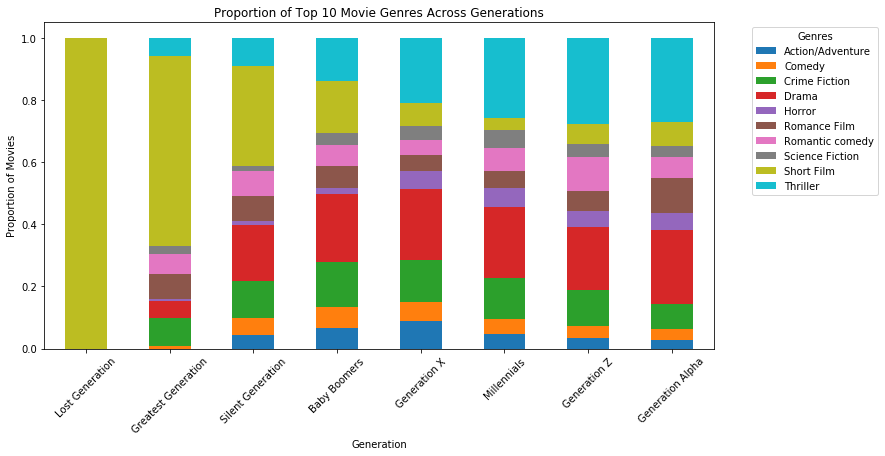

In [73]:
# Normalize the counts to get proportions
genre_by_generation_normalized = genre_by_generation.div(genre_by_generation.sum(axis=1), axis=0)

# Reindex the DataFrame to ensure it's in the order of the generations
genre_by_generation_normalized = genre_by_generation_normalized.reindex(generations_order)

# Plotting a normalized stacked bar chart
genre_by_generation_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proportion of Top 10 Movie Genres Across Generations')
plt.xlabel('Generation')
plt.ylabel('Proportion of Movies')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Ensures generation labels are rotated for better readability
plt.show()



The plot above illustrates the distribution of the top 10 movie genres for each generation. This visualization highlights the shifting landscape of movie genre popularity from the early 20th century to the present day. The following observations were made:

- **Consistent Genres**: Comedy and Drama are consistently popular across all generations, reflecting their enduring appeal.

- **Technological Influence**: The rise in popularity of Science Fiction and Thriller in recent generations may be attributed to advancements in film-making technology.

- **Historical Trends**: Earlier generations such as the Lost and Greatest show a narrower genre focus, likely reflecting the historical limitations of the film industry.

- **Modern Diversification**: Later generations like Millennials, Generation Z, and Alpha exhibit a more balanced genre spread, suggesting a diversification of audience preferences and an industry response to a broader array of interests.


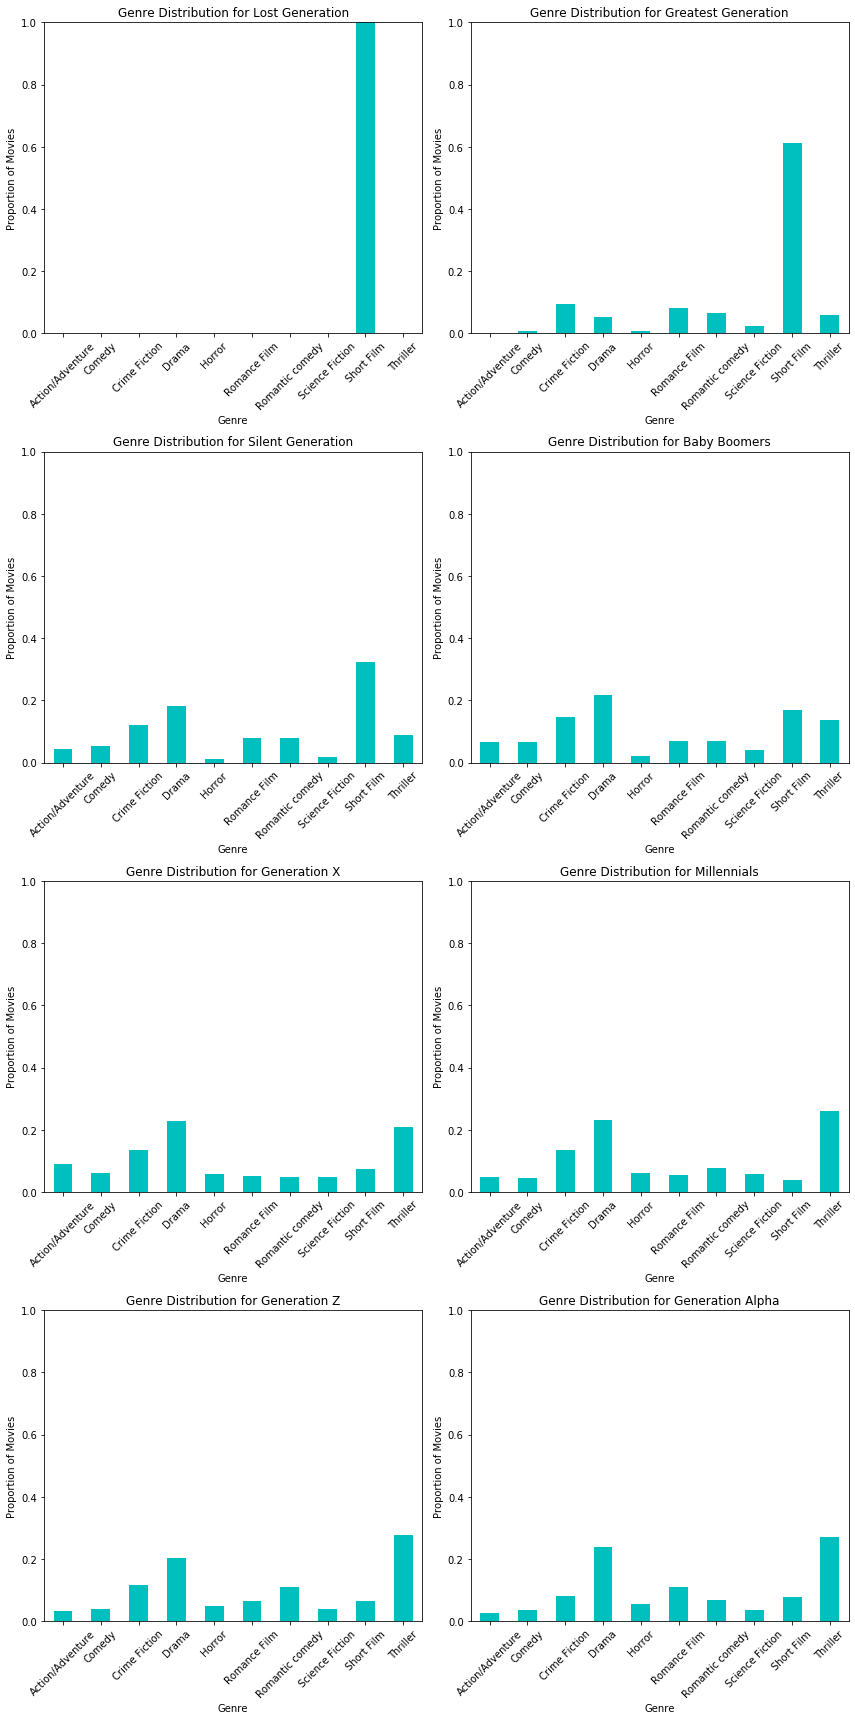

In [74]:
# Layout of the grid
num_generations = len(generations_order)
num_cols = 2  # You can adjust the number of columns based on your preference
num_rows = math.ceil(num_generations / num_cols)

# Subplots in a grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))
axes = axes.flatten()

for i, gen in enumerate(generations_order):
    if gen in genre_by_generation_normalized.index:
        genre_by_generation_normalized.loc[gen].plot(kind='bar', ax=axes[i], color='c', title=f'Genre Distribution for {gen}')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel('Proportion of Movies')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_ylim((0,1))
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()


### Average Movie Runtime Per Generation

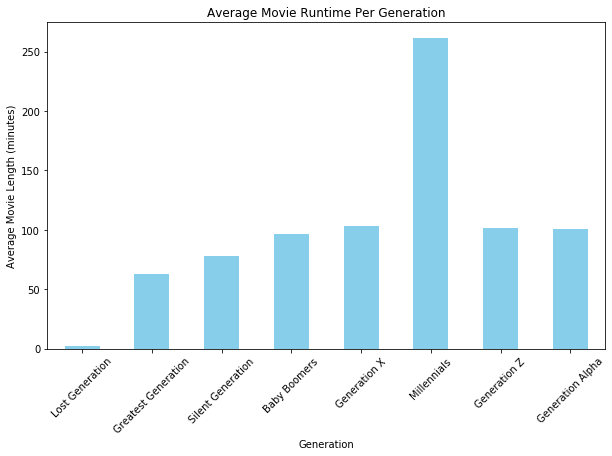

In [75]:
avg_length_per_generation = movies_summary.groupby('Generation')['Movie Runtime'].mean()
sorted_avg_length_per_generation = avg_length_per_generation.reindex(generations['Generation']).fillna(0)

plt.figure(figsize=(10, 6))
sorted_avg_length_per_generation.plot(kind='bar', color='skyblue')
plt.title('Average Movie Runtime Per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Movie Length (minutes)')
plt.xticks(rotation=45)
plt.show()


The bar chart above illustrates significant variability in average movie runtimes when viewed through the lens of generational change. This fluctuation can be attributed to several factors:

- **Technological Advancements**: As film technology evolved, it allowed for more complex storytelling. The advent of sound in movies, for example, during the transition from the Silent Generation to the Baby Boomers, likely contributed to longer runtimes as dialogue became an integral part of film narrative.

- **Economic Factors**: During economic booms, studios might have more budget to produce epic-scale movies with longer runtimes. Conversely, during downturns like the Great Depression (Greatest Generation), more concise films might have been favored to conserve resources and adapt to audiences' financial constraints.

- **Cultural Movements**: The rise of television and other forms of entertainment in the home may have influenced movie lengths. As attention spans adjusted to shorter television programming, this could have been reflected in movie runtimes, particularly noticeable in the shorter films of Generation X compared to the Millennials.

- **Artistic Trends**: The Millennials' peak in runtime could also correlate with the rise of blockbuster franchises and epic series, where more extended runtimes are often used to develop complex storylines and character arcs.

- **Social Change**: Important historical events, such as wars or social movements, could impact film length. For instance, during times of war, there might be a trend towards shorter, morale-boosting films. In contrast, periods of social change might inspire more in-depth explorations of themes, leading to longer films.
